# THIS IS FROM COLAB SO3 DIFFUSION EXAMPLE

In [55]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt 
from scipy.spatial.transform import Rotation


In [56]:
basis = torch.tensor([
    [[0., 0., 0.], [0., 0., -1.], [0., 1., 0.]], 
    [[0., 0., 1.0], [0., 0., 0.], [-1., 0., 0.]], 
    [[0., -1., 0.], [1., 0., 0.], [0., 0., 0.]]])

In [57]:
# hat map from vector space R^3 (axis-angle vector) to Lie algebra so(3), convert to skew-symmetric matrices
def hat(v): 
    """
    Compute the Hat operator of a batch of 3D vectors
    Args:
        v: Batch of vectors of shape `(N, 3)`

    Returns:
        Batch of skew-symmetric matrices of shape `(N, 3, 3)`
        i.e each matrix looks like:
        [[0, -z, y], 
        [z, 0, -x], 
        [-y, x, 0]]
        
    """
    return torch.einsum('...i, ijk->...jk', v, basis)

In [58]:

# logarithmic map from SO(3) to R^3 (i.e. rotation vector)
def Log(x): 
    """
    Convert a batch of 3x3 rotation matrices R to a batch of 3-dimensional matrix
    logarithms of rotation matrices
    the conversion has a singularity around `R=I`
    Args:
        x: batch of rotation matrices of shape `(N, 3, 3)`

    Returns:
        batch of logarithms of rotation matrices of shape `(N, 3)`
    """
    return torch.tensor(Rotation.from_matrix(x.numpy()).as_rotvec())

In [59]:
# logarithmic map from SO(3) to so(3), this the matrix logarithm
def log(x): return hat(Log(x))

In [60]:
# convert so(3) to R3, skew-symmetric matrices to rotation vector
def vee(h): 
    """
    
    Args:
        h: batch of skew-symmetric tensors `(N, 3, 3)`

    Returns:
        Batch of 3d vectors of shape `(N, 3, 3)`
    """
    # skew-symmetric
    assert torch.allclose(h, -h.transpose(-1, -2)), "Input A must be skew symmetric" 
    x = h[..., 2, 1]
    y = h[..., 0, 2]
    z = h[..., 1, 0]
    print("x:", x)
    v = torch.stack((x, y, z), dim=-1)
    return v 



In [61]:
vee(basis)

x: tensor([1., 0., 0.])


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [62]:
basis.shape

torch.Size([3, 3, 3])

In [63]:
# exponential map from so(3) to SO(3), this is the matrix exponential

In [107]:
def exp(r):
    """
    compute so3 exponential map
    Args:
        r: batch of vectors of shape `(N, 3, 3 )` skew-symmetric matrices

    Returns:
        batch of rotation matrices of shape `(N, 3, 3)`
    """
    return torch.linalg.matrix_exp(r)
# exponential map from tangent space at R0 to SO(3)
def expmap(r0, tangent):
    skew_sym = torch.einsum('...ij,...ik->...jk', r0, tangent)
    return torch.einsum('...ij,...jk->...ik', r0, exp(skew_sym))

In [104]:
# calc the rotation angle of SO(3)
def omega(r):
    """
    
    Args:
        r: batch of rotation matrices of shape `(N, 3, 3)` (unit)

    Returns:
       angles 

    """
    return torch.arccos((torch.diagonal(r, dim1=-2, dim2=-1).sum(axis = -1) - 1) / 2)

# calc the relative rotation angle of r0, r1
def angle(r0, r1):
    """
    calculate the angle from r0 to r1
    Args:
        r0: batch of rotation matrices
        r1: batch of rotation matrices

    Returns:
        batch of angles
    omega(torch.matmul(r0.T, r1)), due to warnning (deprecated T)
    omega(torch.matmul(r0.mT, r1)) should be used instead
    """
    return omega(torch.matmul(torch.transpose(r0, -2, -1), r1))

# Define IGSO3 density, the geodesic random walk and check their agreement

In [105]:
# power series expansion in the IGSO3 density
def f_igso3(omega, t, L=500):
    """
    density without 1 - cosw / pi (required)
    With this reparameterization, IGSO(3) agrees with the Brownian motion on
    SO(3) with t=sigma^2 when defined for the canonical inner product on SO3,
    <u, v>_SO3 = Trace(u v^T)/2
    Args:
        omega: rotation angle
        t: sigma^2
        L: 

    Returns:
        density of rotation angle
    """
    ls = torch.arange(L)[None] # [1, L]
    return ((2 * ls + 1) * torch.exp(-ls * (ls + 1) * t / 2) * torch.sin(omega[:, None] * (ls + 1 / 2)) / torch.sin(omega[:, None] / 2)).sum(dim=-1)
    
 # IGSO3(Rt; I_3, t), density with respect to the volume form on SO(3)
def igso3_density(Rt, t, L=500):
     """
     density function on SO(3)
     Args:
         Rt: batch of rotation matrices of shape `(N, 3, 3)` (unit)
         t: 
         L: 

     Returns:

     """
     return f_igso3(omega(Rt), t, L)
 
 # marginal density of rotation angle for uniform density on SO(3).
def angle_density_unif(omega):
     return (1 - torch.cos(omega)) / np.pi  # ??
# its confirmed that igso3  coincides with angle_density_unif when std > 2
# actually igso3_density is consistent with maxwell gausssian

def maxwell_gaussian(omega, std):
    """
    probability density function for maxwell f(x) = sqrt(2/pi) * x^2  exp(-x^2/2sigma^2)
    I'm not sure about sqrt(2/pi)
    Args:
        omega: 
        std: 

    Returns:

    """
    return omega**2 * np.exp(-0.5 * omega**2 / (std ** 2)) * np.sqrt(2 / np.pi)

In [121]:
# Normal sample in tagent space at R0
def tangent_gaussian(r0):
    return torch.einsum('...ij,...jk->...ik', r0, hat(torch.randn(r0.shape[0], 3)))

def p_initial(N):
    return exp(torch.zeros)
# simulation procedure for forward and reverse
def geodesic_random_walk(p_initial, drift, ts):
    rts = [p_initial(), ]
    for i in range(1, len(ts)):
        dt = ts[i] - ts[i-1] # negative for reverse process
        # r_t-1 = exp { simga^2_t - sigma^2_t-1 \nabla log q(rt)  + sqrt(sigma^2_t - sigma^2_t-1) * noisy * r0}
        # sigma^2 = t
        
        rts.append(expmap(rts[i-1], drift(rts[i-1], ts[i-1]) * dt + tangent_gaussian(rts[i-1]) * np.sqrt(abs(dt))))
    return rts 

N = 5000
T  = 5. # final time
# ts = np.linspace(0, T, 200)
ts = torch.linspace(0,  T, 200)

random_walk = geodesic_random_walk(p_initial=lambda: exp(torch.zeros(N, 3, 3)), drift=lambda Rt, t: 0., ts=ts)
        

/tmp/ipykernel_265968/460922388.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rts.append(expmap(rts[i-1], drift(rts[i-1], ts[i-1]) * dt + tangent_gaussian(rts[i-1]) * np.sqrt(abs(dt))))


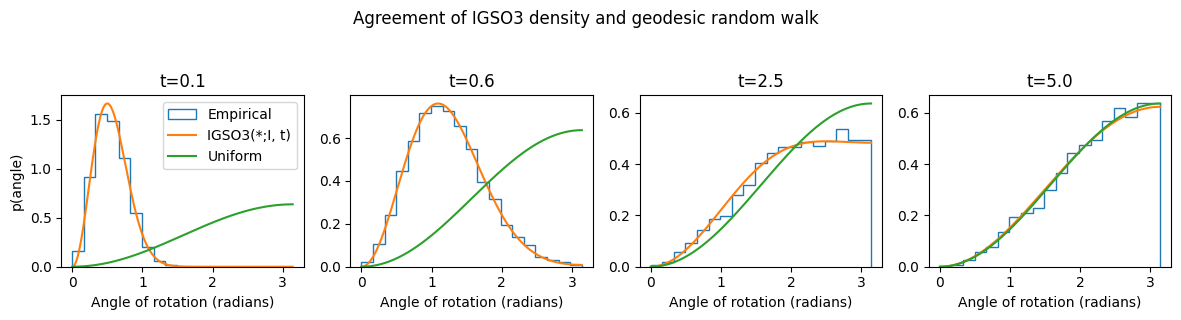

In [109]:
t_idcs_plot = [5, 25, 100, -1] # totally 200, 0-199
_, axs = plt.subplots(1, len(t_idcs_plot), dpi=100, figsize=(3*len(t_idcs_plot), 3))
for i, t_idx in enumerate(t_idcs_plot):
  # Plot empirical distribution of angle of rotation from geodesic random walk
  bins = np.linspace(0, np.pi, 20)
  axs[i].hist(omega(random_walk[t_idx]), bins=bins, density=True, histtype='step', label='Empirical')
  axs[i].set_title(f"t={ts[t_idx]:0.01f}")

  
  # Compute density on angle of rotation, and the density for the uniform distribution
  omega_grid = torch.linspace(0, np.pi, 1000)
  # !! how to calc density!!! * angle_density_unif
  pdf_angle = f_igso3(omega_grid, ts[t_idx])*angle_density_unif(omega_grid)
  axs[i].plot(omega_grid, pdf_angle.numpy(), label="IGSO3(*;I, t)")
  axs[i].plot(omega_grid, angle_density_unif(omega_grid).numpy(), label="Uniform")

  axs[i].set_xlabel("Angle of rotation (radians)")
axs[0].legend()
axs[0].set_ylabel("p(angle)")

plt.suptitle("Agreement of IGSO3 density and geodesic random walk", y=1.05)
plt.tight_layout()
plt.show()

# Define toy target, intermediate and invariant densities:
* $p_0(\cdot)=N_{atoms}^{-1}\sum_{n=1}^{N_{{atoms}}} \delta_{R_n}(\cdot)$, where each $\delta_R$ is as Dirac mass on an arbitrary, fixed rotation $R_n.$
* Invariant $p_{inv}(\cdot)=U_{SO3}(\cdot)$
* Intermediate $p_t(\cdot)=N_{atoms}^{-1}\sum_{n=1}^{N_{atoms}}p_{t|0}(\cdot|R_n)$ score of the noised distribution for each t, and geodesic 
random walk for sampling for the forward and reverse processes

And additionally define the score, $\nabla_{R} logp_{t}(R)$ for each t and R using automatic differentiation


In [110]:
# sample N times from u(SO(3)) by inverting cdf of uniform distrubution of angle
def p_inv(N, M=1000):
    """
    cdf, fX(x) = p, p is uniform distribution.
    sample u to get x. inverse tranforming sample
    Args:
        N: SAMPLES
        M: default data of M

    Returns:

    """
    omega_grid = torch.linspace(0, np.pi, M)
    cdf = np.cumsum(angle_density_unif(omega_grid).numpy()) / (M / np.pi)
    
    omegas = np.interp(np.random.rand(N), cdf, omega_grid)
    axes = np.random.rand(N, 3)
    # unit(axes) * omega
    axes = omegas[:, None] * axes / np.linalg.norm(axes, axis=-1, keepdims=True)
    return exp(hat(torch.tensor(axes)))


In [111]:
# define discrete target measure on SO(3), and it's score for t>0
N_atoms = 3
mu_ks = p_inv(N_atoms) # ATOMS defining target measure

In [112]:
# sample p_0 ~ (1/N_ATOMS) \ sum_k Dirac_(mu_k)
def p_0(N):
    return mu_ks[torch.randint(mu_ks.shape[0], size=[N])]


In [123]:
mu_ks

tensor([[[ 0.8244,  0.1211,  0.5530],
         [ 0.5530, -0.3810, -0.7410],
         [ 0.1210,  0.9166, -0.3810]],

        [[-0.9910,  0.0460,  0.1261],
         [ 0.1342,  0.3468,  0.9283],
         [-0.0010,  0.9368, -0.3498]],

        [[-0.2461, -0.3157,  0.9164],
         [ 0.3543, -0.9093, -0.2182],
         [ 0.9022,  0.2710,  0.3356]]])

In [122]:
p_0(3)

tensor([[[-0.2461, -0.3157,  0.9164],
         [ 0.3543, -0.9093, -0.2182],
         [ 0.9022,  0.2710,  0.3356]],

        [[-0.9910,  0.0460,  0.1261],
         [ 0.1342,  0.3468,  0.9283],
         [-0.0010,  0.9368, -0.3498]],

        [[-0.9910,  0.0460,  0.1261],
         [ 0.1342,  0.3468,  0.9283],
         [-0.0010,  0.9368, -0.3498]]])

In [117]:
torch.randint(3, size=[3])

tensor([0, 1, 2])

In [118]:
# density of discrete target noised for time t
def p_t(rt, t): 
    return sum([igso3_density(torch.einsum('ji,...jk->...ik', mu_k, rt), t) for mu_k in mu_ks]) / N_atoms

In [119]:
# riemannian gradient of f at R using automatic differentiation
def riemannian_gradient(f, r):
    coeff = torch.zeros(list(r.shape[:-2]) + [3], requires_grad = True)
    R_delta = expmap(r, torch.einsum('...ij,...jk->...ik', r, hat(coeff)))
    grad_coeff = torch.autograd.grad(f(R_delta).sum(), coeff)[0]
    return torch.einsum('...ij,...jk->...ik', r, hat(grad_coeff))

In [120]:
# stein score of p_t
def score_t(rt, t):
    return riemannian_gradient(lambda r_: torch.log(p_t(r_, t)), rt)

# simulate the forward and reverse processes

In [124]:
forward_samples = geodesic_random_walk(p_initial=lambda: p_0(N), drift =lambda Rt, t: 0., ts=ts)

/tmp/ipykernel_265968/460922388.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rts.append(expmap(rts[i-1], drift(rts[i-1], ts[i-1]) * dt + tangent_gaussian(rts[i-1]) * np.sqrt(abs(dt))))


In [125]:
reverse_samples = geodesic_random_walk(p_initial=lambda: p_inv(N), drift=lambda Rt, t: -score_t(Rt, t), ts=ts)

/tmp/ipykernel_265968/460922388.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rts.append(expmap(rts[i-1], drift(rts[i-1], ts[i-1]) * dt + tangent_gaussian(rts[i-1]) * np.sqrt(abs(dt))))


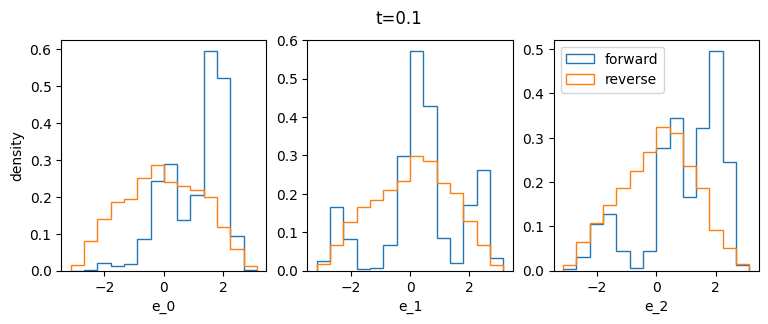

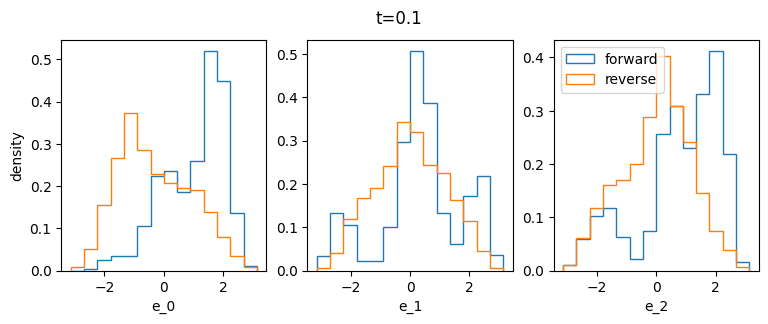

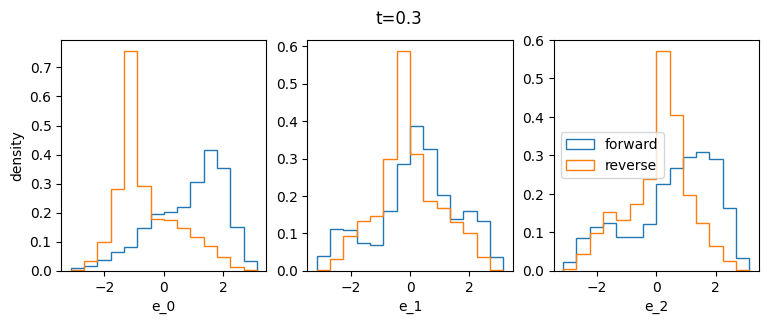

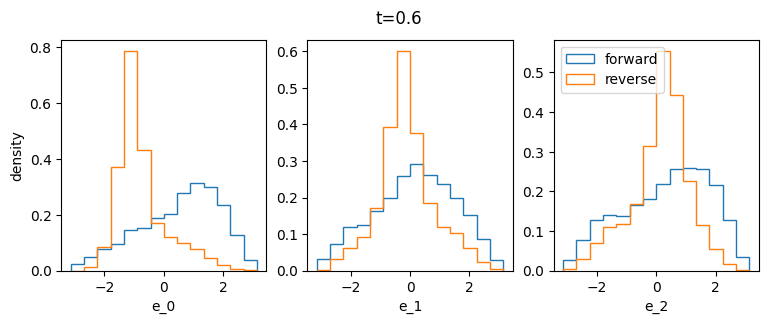

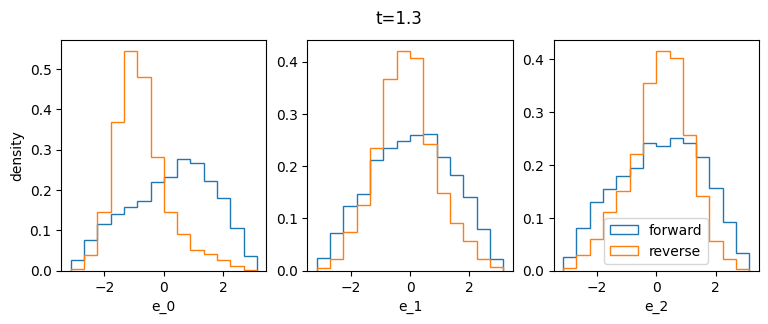

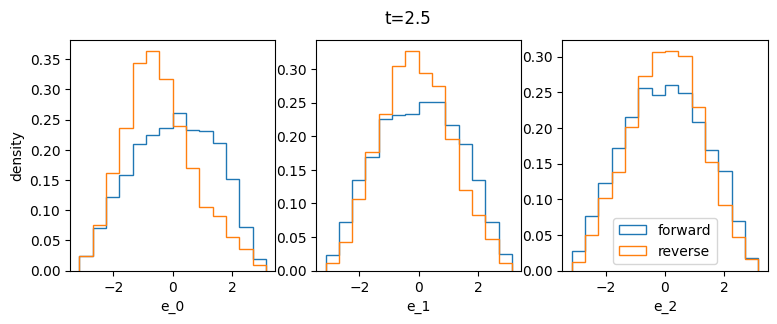

In [126]:
# Plot comparison of forward and reverse process in orthormal basis of so(3)
for i in [3, 5, 10, 25, 50, 100]:
    t = ts[i]
    Rt_forward = Log(forward_samples[i])
    Rt_reverse = Log(reverse_samples[i])
    fig, axs = plt.subplots(1, 3, dpi=100, figsize=(9, 3))
    fig.suptitle(f't={t:.1f}')
    bins = np.linspace(-np.pi, np.pi, 15)
    for Rt, label in [(Rt_forward, "forward"), (Rt_reverse, "reverse")]:
        axs[0].set_ylabel("density")
        for i in range(3):
            axs[i].hist(Rt[:, i].numpy(), bins, density=True, histtype='step', label=label)
            axs[i].set_xlabel(f"e_{i}")
    plt.legend()

In [127]:
r0= torch.rand((2, 3, 3))
r1= torch.rand((2, 3, 3))

In [129]:
r0.mT

tensor([[[0.5379, 0.6574, 0.3306],
         [0.7558, 0.3225, 0.8981],
         [0.7539, 0.2098, 0.7898]],

        [[0.2872, 0.7461, 0.6855],
         [0.4913, 0.7958, 0.6593],
         [0.4046, 0.3108, 0.7625]]])

In [130]:
torch.matmul(r0.mT, r1)

tensor([[[0.9077, 0.9018, 1.0573],
         [1.3316, 0.7799, 1.0703],
         [1.2065, 0.6407, 0.9363]],

        [[0.8059, 0.4814, 0.6352],
         [0.9469, 0.5232, 0.6256],
         [0.4957, 0.3091, 0.6725]]])